<a href="https://colab.research.google.com/github/estebansalas18/clasificador-imagenes/blob/main/clasificador_de_vehiculos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input, MaxPooling2D, Activation
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import random
import shutil
import os
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
classes = ['Bicycle', 'Boat', 'Bus', 'Car', 'Motorcycle', 'Truck', 'Van']
n_classes = len(classes)

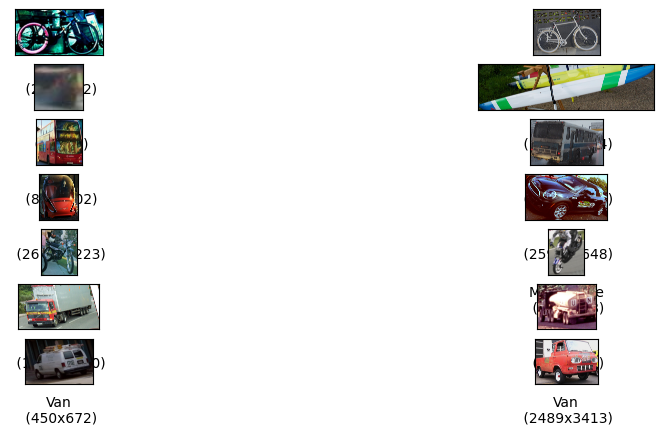

In [ ]:
#Showing radom images from each class in dataset
plt.figure(figsize=(12,12))
count = 0
for i, cls in enumerate(classes):
  for j in range(2):
    dir = f'/kaggle/input/vehicle/train/train/{cls}'
    filename = random.choice(os.listdir(dir))
    path = os.path.join(dir, filename)
    img = plt.imread(path)
    count += 1
    plt.subplot(17,2,count)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    plt.xlabel(f'{cls}\n ({img.shape[0]}x{img.shape[1]})')

plt.show()

In [ ]:
#Load and transform images in tensorflow

datagen = ImageDataGenerator(
    validation_split=0.2, 
    rescale=1./255,
  )

train_generator = datagen.flow_from_directory(
    '/kaggle/input/vehicle/train/train',
    target_size=(224, 224),
    batch_size=32,seed=123,
    subset='training',
    color_mode="rgb",
    class_mode='sparse',
    classes=classes
)
valid_generator = datagen.flow_from_directory(
    '/kaggle/input/vehicle/train/train',
    target_size=(224, 224),
    batch_size=32,seed=123,
    subset='validation',
    class_mode='sparse',
    color_mode="rgb",
    classes=classes
)

Found 20288 images belonging to 7 classes.
Found 5069 images belonging to 7 classes.


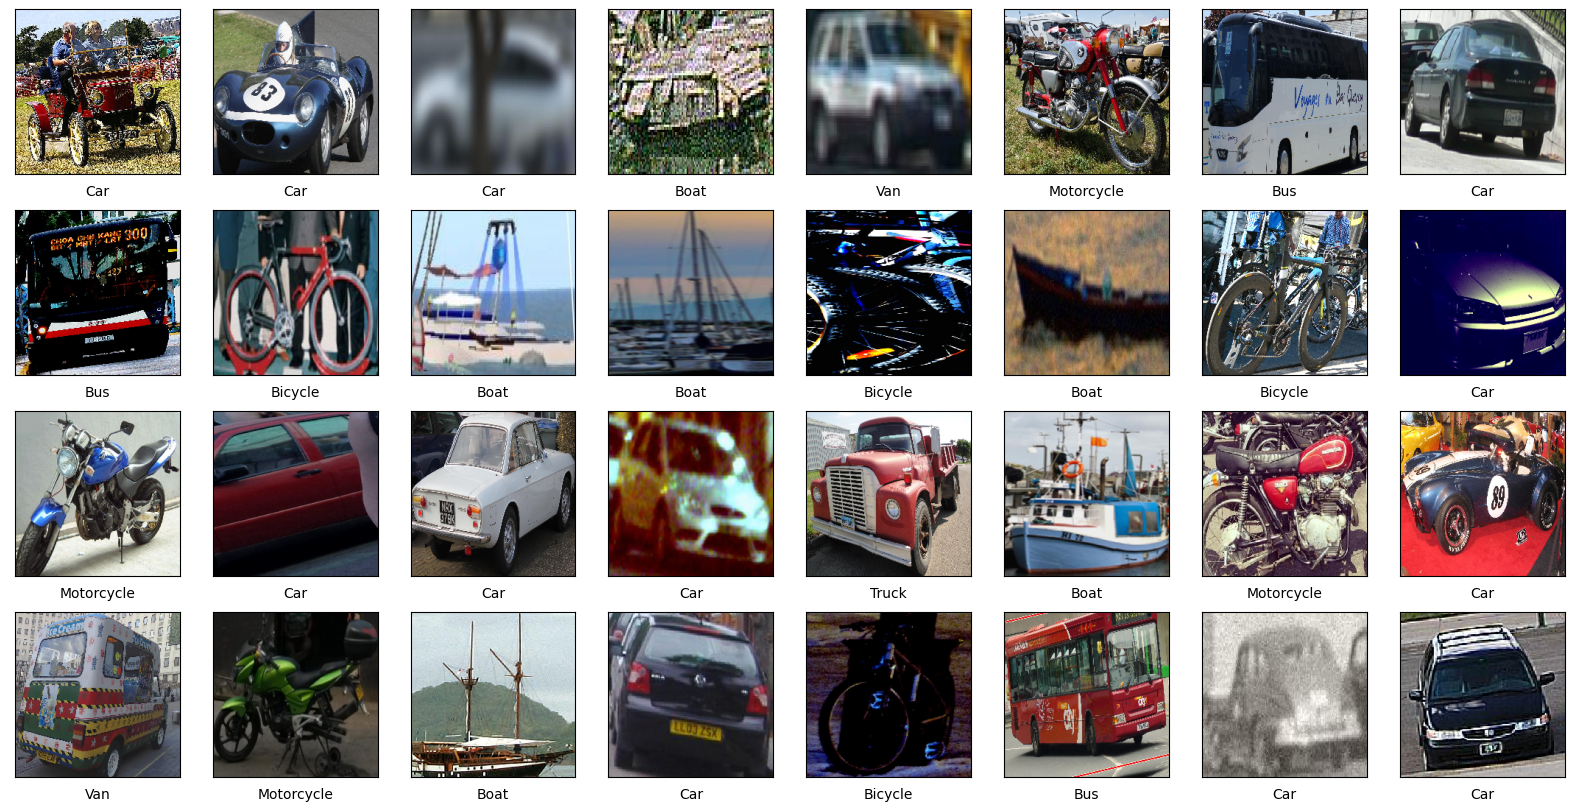

In [ ]:
#showing images after transformations

import numpy as np
fig = plt.figure(figsize=(20,10))
imgs,lbls = train_generator.next()
for i in range(0,32):
  plt.subplot(4,8,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imgs[i].reshape((224,224, 3)), cmap='gray')
  plt.xlabel(classes[int(lbls[i])])
plt.show()

In [ ]:
#Compute Class weights
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight('balanced', classes=range(n_classes), y=valid_generator.labels.astype(int))
class_weight = dict(zip(range(len(class_weight)), class_weight))
class_weight

{0: 2.2419283502874836,
 1: 0.41641337386018235,
 2: 1.6998658618376927,
 3: 0.5340286557100716,
 4: 1.2129696099545346,
 5: 1.7836030964109781,
 6: 3.261904761904762}

In [ ]:
#defining metrics

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# from sklearn.metrics import multilabel_confusion_matrix
def conf_matrix_m(y_true, y_pred):
  return tf.math.confusion_matrix(y_true, K.argmax(y_pred), num_classes=n_classes)

In [ ]:
# CNN model

model = Sequential()

#### Input Layer ####
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(224, 224, 3)))

#### Convolutional Layers ####
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))  # Pooling
model.add(Dropout(0.5)) # Dropout

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (5,5), padding='same', activation='relu'))
model.add(Conv2D(512, (5,5), activation='relu'))
model.add(MaxPooling2D((4,4)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

#### Fully-Connected Layer ####
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation='softmax'))

# model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer="Nadam",
              metrics=['accuracy', f1_m, conf_matrix_m, precision_m, recall_m ]
              )


In [ ]:
#Train the model
history =model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=20,
                    validation_data=valid_generator,
                    validation_steps = len(valid_generator),
                    class_weight=class_weight,
                  )

Epoch 1/20


2023-05-28 23:12:10.030402: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


634/634 [==============================] - 245s 376ms/step - loss: 3.2687 - accuracy: 0.3545 - f1_m: 1.7927 - conf_matrix_m: 0.6531 - precision_m: 2.4694 - recall_m: 1.4780 - val_loss: 1.4213 - val_accuracy: 0.4752 - val_f1_m: 2.3965 - val_conf_matrix_m: 0.6506 - val_precision_m: 4.8390 - val_recall_m: 1.6303
Epoch 2/20
634/634 [==============================] - 236s 373ms/step - loss: 1.2490 - accuracy: 0.5295 - f1_m: 2.0385 - conf_matrix_m: 0.6531 - precision_m: 2.9151 - recall_m: 1.5905 - val_loss: 1.1793 - val_accuracy: 0.5776 - val_f1_m: 1.6657 - val_conf_matrix_m: 0.6506 - val_precision_m: 1.9273 - val_recall_m: 1.4769
Epoch 3/20
634/634 [==============================] - 239s 376ms/step - loss: 1.0537 - accuracy: 0.6016 - f1_m: 1.8261 - conf_matrix_m: 0.6531 - precision_m: 2.2995 - recall_m: 1.5289 - val_loss: 0.9621 - val_accuracy: 0.6713 - val_f1_m: 1.4288 - val_conf_matrix_m: 0.6506 - val_precision_m: 1.5380 - val_recall_m: 1.3396
Epoch 4/20
634/634 [=========================

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

y_pred = []
y_true = []
valid_generator.reset()
for i in range(88):
  x,y = valid_generator.next()
  y_true += y.astype(int).tolist()
  y_pred += list(np.argmax(model.predict(x), axis=1))

1/1 [==============================] - 0s 28ms/step


In [ ]:
cm = tf.math.confusion_matrix(y_true, y_pred)

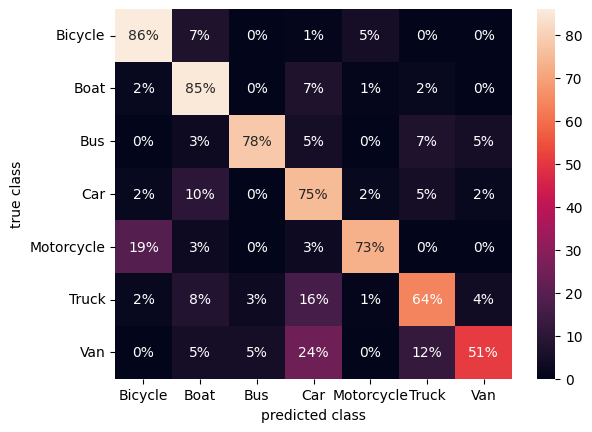

In [ ]:
#Confusion matrix

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(cm)
df_cm= df_cm.astype(int)
df_cm.index = classes
df_cm.columns = classes

# Calcula los porcentajes en la matriz de confusión
df_cm_pct = df_cm.apply(lambda x: x / x.sum() * 100, axis=1)

# Configura el formato de los valores en la matriz de confusión
df_cm_pct = df_cm_pct.astype(int)

# Configura los valores de las anotaciones en porcentaje con el signo %
annot_values = df_cm_pct.astype(str) + '%'

# Grafica la matriz de confusión en forma de heatmap con el signo %
sn.heatmap(df_cm_pct, annot=annot_values, fmt='', annot_kws={"fontsize": 10})
plt.ylabel('true class')
plt.xlabel('predicted class')
plt.show()

ROC AUC score: 0.8464515246198154


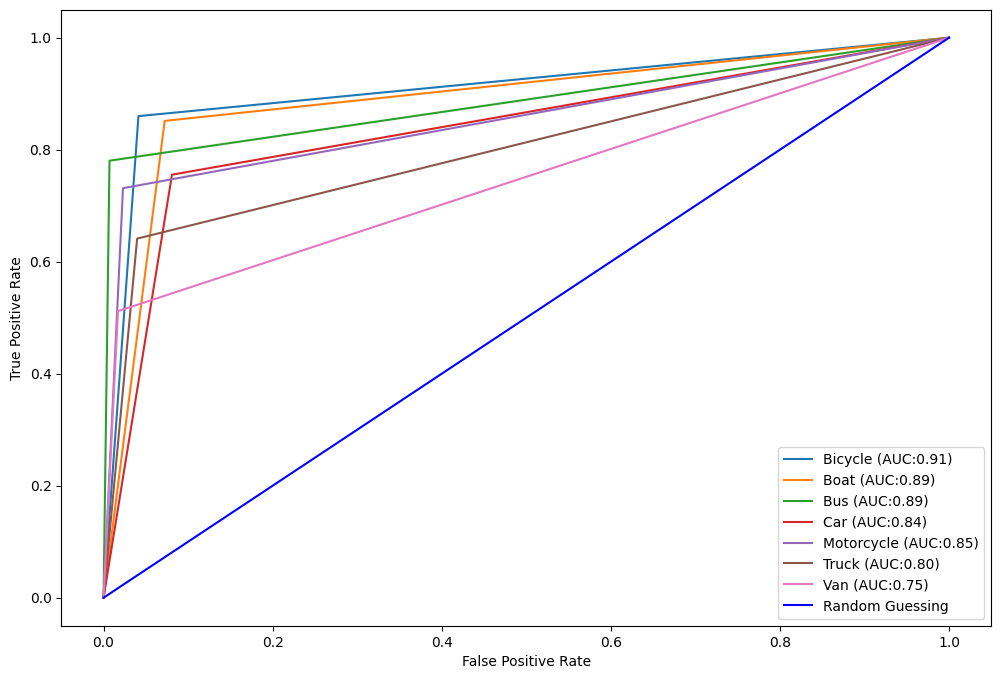

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score,confusion_matrix, balanced_accuracy_score, roc_curve, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, auc
import seaborn as sns
import numpy as np
from pylab import savefig
from scipy import interp
from itertools import cycle

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    target = classes
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

print('ROC AUC score:', multiclass_roc_auc_score(y_true, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()


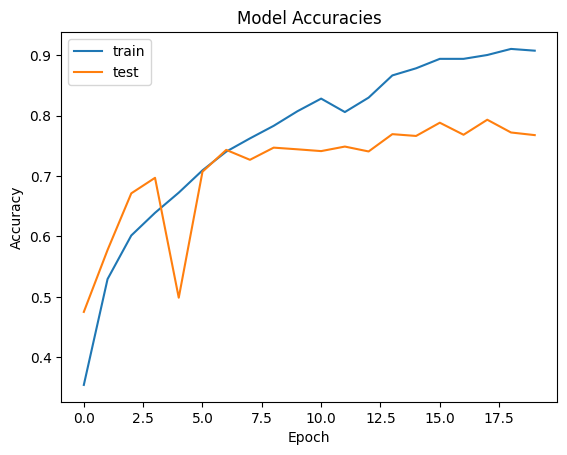

In [ ]:
#showing accuracy over epochs

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

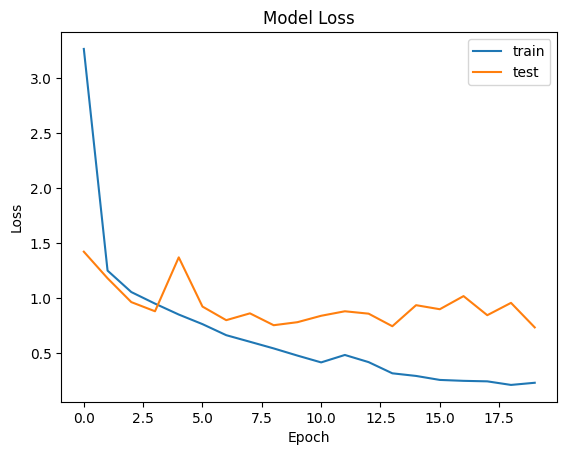

In [ ]:
#showing loss over epochs

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

1/1 [==============================] - 0s 20ms/step


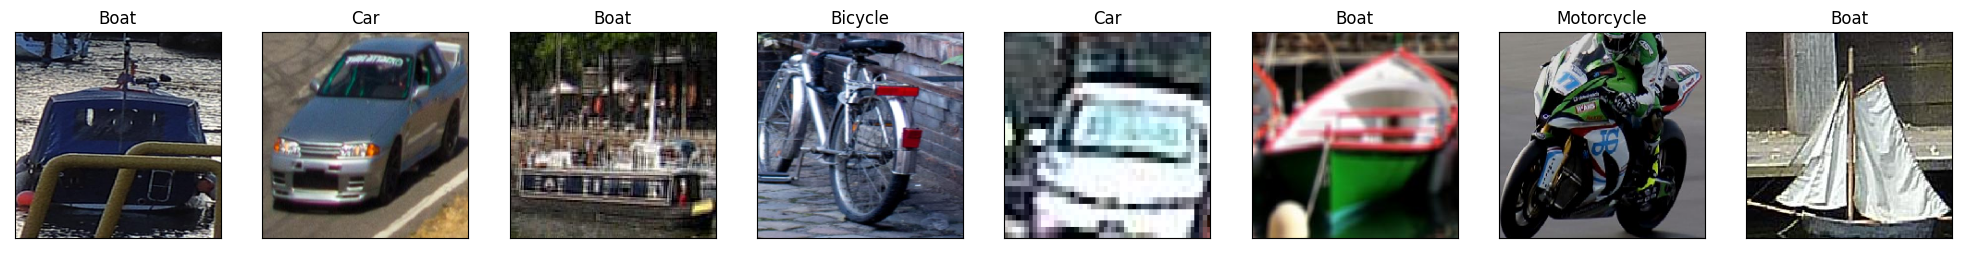

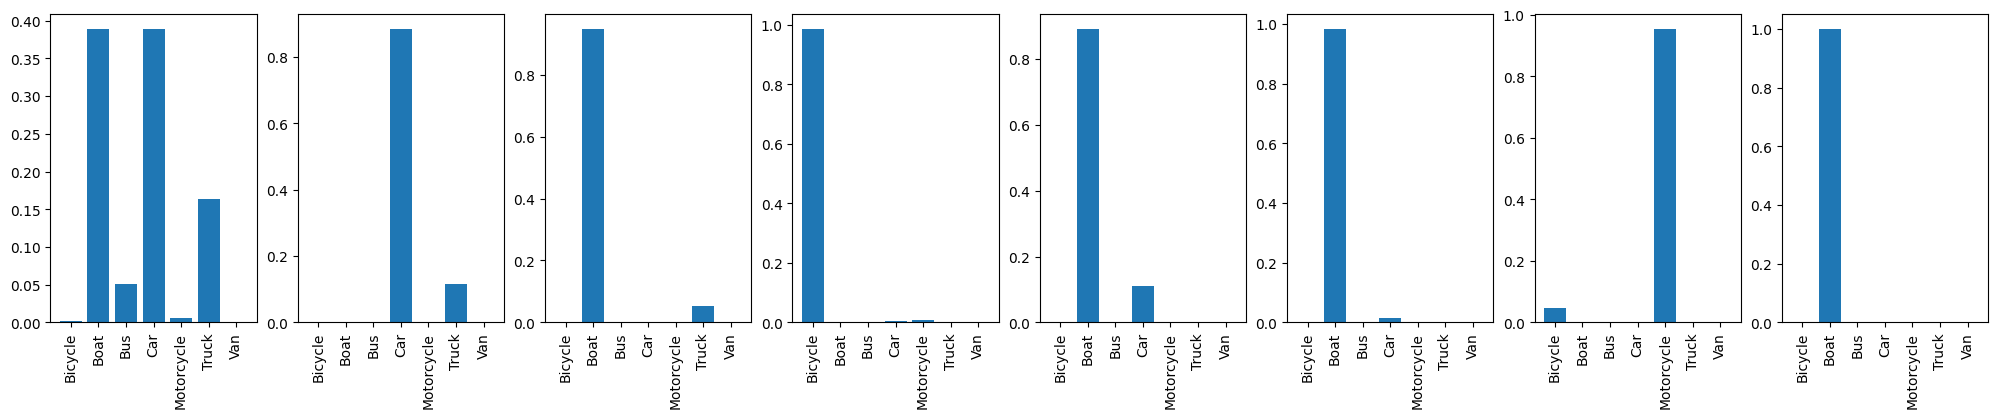

In [ ]:
import random

# Obtener índices aleatorios para las imágenes de validación
indices = random.sample(range(valid_generator[0][0].shape[0]), 8)

fig = plt.figure(figsize=(25, 10))
for i, idx in enumerate(indices):
    plt.subplot(1, 8, i + 1)
    img = valid_generator[0][0][idx]
    plt.imshow(img.reshape(224, 224, 3))
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)[0]
    plt.xticks([])
    plt.yticks([])
    plt.title(classes[int(valid_generator[0][1][idx])])

fig = plt.figure(figsize=(25, 4))
for i, idx in enumerate(indices):
    plt.subplot(1, 8, i + 1)
    img = valid_generator[0][0][idx]
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)[0]
    prob = {i: j for i, j in zip(classes, list(pred))}
    plt.bar(prob.keys(), prob.values())
    plt.xticks(rotation='vertical')

plt.show()
